## Pré-treinamento não supervisionado Greedy Layer-Wise

Nesta seção, exploraremos o uso de pré-treinamento guloso em camadas com um modelo não supervisionado.

Especificamente, desenvolveremos um modelo de autoencoder que será treinado para reconstruir os dados de entrada. Para usar este modelo não supervisionado para classificação, removeremos a camada de saída, adicionaremos e ajustaremos uma nova camada de saída para classificação.

Isso é um pouco mais complexo do que o pré-treinamento guloso supervisionado anterior, mas podemos reutilizar muitas das mesmas ideias e códigos da seção anterior.

A primeira etapa é definir, ajustar e avaliar um modelo de autoencoder. Usaremos o mesmo modelo básico de duas camadas da seção anterior, exceto modificá-lo para prever a entrada como saída e usar o erro médio quadrado para avaliar a qualidade do modelo na reconstrução de uma determinada amostra de entrada.

A função base_autoencoder() abaixo implementa isso, pegando os conjuntos de treinamento e teste como argumentos e, em seguida, define, ajusta e avalia o modelo base do autoencoder não supervisionado, imprimindo o erro de reconstrução nos conjuntos de treinamento e teste e retornando o modelo.
Mais sobre o texto originalÉ necessário fornecer o texto original para ver mais informações sobre a tradução
Enviar feedback
Painéis laterais

In [28]:
# unsupervised greedy layer-wise pretraining for blobs classification problem
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

In [29]:
# prepare the dataset
def prepare_data():
	# generate 2d classification dataset
	X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
	# one hot encode output variable
	y = to_categorical(y)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	return trainX, testX, trainy, testy

In [30]:
# prepare data
trainX, testX, trainy, testy = prepare_data()

In [31]:
trainX.shape

(500, 2)

In [32]:
# define, fit and evaluate the base autoencoder
def base_autoencoder(trainX, testX):
	# define model
	model = Sequential()
	model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(2, activation='linear'))
	# compile model
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
	return model

We can call this function in order to prepare our base autoencoder to which we can add and greedily train layers.

In [33]:
# get the base autoencoder
model = base_autoencoder(trainX, testX)
model.summary()

> reconstruction error train=0.001, test=0.001
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 22        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


Evaluating an autoencoder model on the blobs multi-class classification problem requires a few steps.

The hidden layers will be used as the basis of a classifier with a new output layer that must be trained then used to make predictions before adding back the original output layer so that we can continue to add layers to the autoencoder.

The first step is to reference, then remove the output layer of the autoencoder model.

In [34]:
# remember the current output layer
output_layer = model.layers[-1]
# remove the output layer
model.pop()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                30        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


All of the remaining hidden layers in the autoencoder must be marked as non-trainable so that the weights are not changed when we train the new output layer.

In [35]:
# mark all remaining layers as non-trainable
for layer in model.layers:
    layer.trainable = False

We can now add a new output layer that predicts the probability of an example belonging to reach of the three classes. The model must also be re-compiled using a new loss function suitable for multi-class classification.

In [36]:
# add new output layer
model.add(Dense(3, activation='softmax'))
# compile model
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 33        
Total params: 63
Trainable params: 33
Non-trainable params: 30
_________________________________________________________________


The model can then be re-fit on the training dataset, specifically training the output layer on how to make class predictions using the learned features from the autoencoder as input.

The classification accuracy of the fit model can then be evaluated on the train and test datasets.

In [37]:
# fit model
model.fit(trainX, trainy, epochs=100, verbose=0)
# evaluate model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

In [43]:
train_acc

0.7559999823570251

Finally, we can put the autoencoder back together but removing the classification output layer, adding back the original autoencoder output layer and recompiling the model with an appropriate loss function for reconstruction.

In [39]:
# put the model back together
model.pop()
model.add(output_layer)
model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 22        
Total params: 52
Trainable params: 22
Non-trainable params: 30
_________________________________________________________________


We can tie this together into an evaluate_autoencoder_as_classifier() function that takes the model as well as the train and test sets, then returns the train and test set classification accuracy.

In [26]:
# evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add new output layer
	model.add(Dense(3, activation='softmax'))
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	# evaluate model
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	# put the model back together
	model.pop()
	model.add(output_layer)
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	return train_acc, test_acc

This function can be called to evaluate the baseline autoencoder model and then store the accuracy scores in a dictionary against the number of layers in the model (in this case two).

In [40]:
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)

> classifier accuracy layers=2, train=0.812, test=0.836


We are now ready to define the process for adding and pretraining layers to the model.

The process for adding layers is much the same as the supervised case in the previous section, except we are optimizing reconstruction loss rather than classification accuracy for the new layer.

The add_layer_to_autoencoder() function below adds a new hidden layer to the autoencoder model, updates the weights for the new layer and the hidden layers, then reports the reconstruction error on the train and test sets input data. The function does re-mark all prior layers as non-trainable, which is redundant because we already did this in the evaluate_autoencoder_as_classifier() function, but I have left it in, in case you decide to reuse this function in your own project.

In [16]:
# add one new layer and re-train only the new layer
def add_layer_to_autoencoder(model, trainX, testX):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer
	model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

We can now repeatedly call this function, adding layers, and evaluating the effect by using the autoencoder as the basis for evaluating a new classifier.

In [41]:
# add layers and evaluate the updated model
n_layers = 5
for _ in range(n_layers):
	# add layer
	add_layer_to_autoencoder(model, trainX, testX)
	# evaluate model
	train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
	print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)
model.summary()

> reconstruction error train=0.008, test=0.010
> classifier accuracy layers=3, train=0.810, test=0.840
> reconstruction error train=2.649, test=2.851
> classifier accuracy layers=4, train=0.750, test=0.750
> reconstruction error train=2.177, test=2.475
> classifier accuracy layers=5, train=0.764, test=0.762
> reconstruction error train=2.174, test=2.477
> classifier accuracy layers=6, train=0.766, test=0.768
> reconstruction error train=2.186, test=2.479
> classifier accuracy layers=7, train=0.756, test=0.764
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_37 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_39 (Dense)             (None, 10)                110       
_

As before, all accuracy scores are collected and we can use them to create a line graph of the number of model layers vs train and test set accuracy.

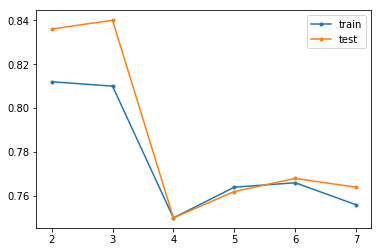

In [42]:
# plot number of added layers vs accuracy
keys = list(scores.keys())
pyplot.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
pyplot.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
pyplot.legend()
pyplot.show()

> reconstruction error train=0.000, test=0.000
> classifier accuracy layers=2, train=0.832, test=0.836
> reconstruction error train=0.023, test=0.028
> classifier accuracy layers=3, train=0.806, test=0.828
> reconstruction error train=10.409, test=10.682
> classifier accuracy layers=4, train=0.342, test=0.326
> reconstruction error train=10.408, test=10.669
> classifier accuracy layers=5, train=0.342, test=0.326
> reconstruction error train=10.409, test=10.679
> classifier accuracy layers=6, train=0.342, test=0.326
> reconstruction error train=10.408, test=10.668
> classifier accuracy layers=7, train=0.342, test=0.326


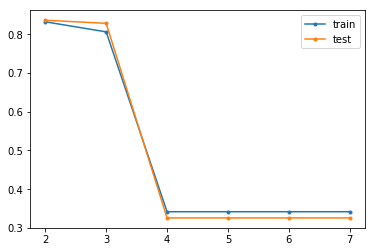

In [19]:
# unsupervised greedy layer-wise pretraining for blobs classification problem
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

# prepare the dataset
def prepare_data():
	# generate 2d classification dataset
	X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
	# one hot encode output variable
	y = to_categorical(y)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	return trainX, testX, trainy, testy

# define, fit and evaluate the base autoencoder
def base_autoencoder(trainX, testX):
	# define model
	model = Sequential()
	model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(2, activation='linear'))
	# compile model
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
	return model

# evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add new output layer
	model.add(Dense(3, activation='softmax'))
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	# evaluate model
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	# put the model back together
	model.pop()
	model.add(output_layer)
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	return train_acc, test_acc

# add one new layer and re-train only the new layer
def add_layer_to_autoencoder(model, trainX, testX):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer
	model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

# prepare data
trainX, testX, trainy, testy = prepare_data()
# get the base autoencoder
model = base_autoencoder(trainX, testX)
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)
# add layers and evaluate the updated model
n_layers = 5
for _ in range(n_layers):
	# add layer
	add_layer_to_autoencoder(model, trainX, testX)
	# evaluate model
	train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
	print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)
# plot number of added layers vs accuracy
keys = list(scores.keys())
pyplot.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
pyplot.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
pyplot.legend()
pyplot.show()

In this case, we can see that reconstruction error starts low, in fact near-perfect, then slowly increases during training. Accuracy on the training dataset seems to decrease as layers are added to the encoder, although accuracy test seems to improve as layers are added, at least until the model has five layers, after which performance appears to crash.